Import the required modules

In [ ]:
import torch # Pytorch
import numpy as np
import matplotlib.pyplot as plt

Select the device for performing the computations. ```torch.cuda.is_available()``` is ```True``` if graphic card supporting ```CUDA``` is available. If $n$ graphics cards are available, graphic card $m$, $0 \leq m \leq (n-1)$, can be used by "cuda:$m$".
Select the default data type for ```torch.Tensor``` such as ```torch.float32``` (32-bit floating point), ```torch.float64``` (64-bit floating point) or ```torch.float16``` (16-bit floating point).

In [ ]:
# Select device and Data type
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

dtype = torch.float32

**Problem setup**

Input, output and other matrices/vectors are defined in terms of ```torch.Tensor```. A ```torch.Tensor``` can be allocated to CPU or to GPU by specifying ```device``` argument. Data type can be specified by specifying argument ```dtype```. ```.numpy()``` returns the tensor as NumPy ```ndarray```.

In [ ]:
num_samples = 1000 # Number of samples
sample_dim = 2 # Input dimensions
label_dim = 3 # Output dimensions
hidden_dim = 10 # Hidden layer dimensions / Number of neurons

# Input parameters
x = torch.rand(num_samples, sample_dim).to(device=device).to(dtype=dtype) * 2 - 1

# True Weight and Bias parameter
w1 = torch.rand(label_dim, sample_dim).to(device=device).to(dtype=dtype)
b1 = torch.rand(label_dim, 1).to(device=device).to(dtype=dtype)

# Output values
y = torch.sin(torch.matmul(w1, x.T) + b1).T

# w1 = torch.rand(hidden_dim, sample_dim).to(device=device)
# b1 = torch.rand(hidden_dim, 1).to(device=device)

# w2 = torch.rand(label_dim, hidden_dim).to(device=device)
# b2 = torch.rand(label_dim, 1).to(device=device)

# y = torch.sin(torch.matmul(w2, torch.sin(torch.matmul(w1, x.T) + b1)) + b2).T

print(f"Input - Shape: {x.shape}, Device: {x.device}, Data type: {x.dtype}")
print(f"Output - Shape: {y.shape}, Device {y.device}, Data type: {y.dtype}")
if x.device == "cpu":
  print(f"Input in NumPy: \n {x.numpy()}")
else:
  print(f"Input in NumPy: \n {x.cpu().numpy()}")

Input - Shape: torch.Size([1000, 2]), Device: cuda:0, Data type: torch.float32
Output - Shape: torch.Size([1000, 3]), Device cuda:0, Data type: torch.float32
Input in NumPy: 
 [[ 0.26556277 -0.19017243]
 [ 0.54225695  0.813377  ]
 [-0.65788615 -0.86627245]
 ...
 [ 0.3622831  -0.5096818 ]
 [-0.5690993   0.10198534]
 [ 0.10045409 -0.17743206]]


We now define the Artificial Neural Network (ANN). ```torch.nn.Module``` is base class for ANN modules. Class ```net``` should should implement ```forward``` method, which implements forward pass of the ANN. Weights and biases of the ANN can be read from ```.parameters()```. ANN can be moved to a device by specifying ```device``` and data type of weights and biases can be specified by ```dtype```.

In [ ]:
# Artificial Neural Network
class Net(torch.nn.Module):
  def __init__(self, sample_dim, label_dim, activation_function):
    super().__init__()
    self.Linear1 = torch.nn.Linear(sample_dim, label_dim)
    self.activation_function = activation_function

  def forward(self, x_para):
    output_val = self.activation_function(self.Linear1(x_para))
    return output_val

net = Net(sample_dim, label_dim, torch.sin).to(device=device).to(dtype=dtype)

# class Net(torch.nn.Module):
#   def __init__(self, sample_dim, hidden_dim, label_dim, activation_function):
#     super().__init__()
#     self.Linear1 = torch.nn.Linear(sample_dim, hidden_dim)
#     self.Linear2 = torch.nn.Linear(hidden_dim, label_dim)
#     self.activation_function = activation_function

#   def forward(self, x_para):
#     hidden_val = self.activation_function(self.Linear1(x_para))
#     output_val = self.activation_function(self.Linear2((hidden_val)))
#     return output_val

# net = Net(sample_dim, hidden_dim, label_dim, torch.sin).to(device=device)

for param in net.parameters():
  print(f"NN parameter Shape: {param.shape}, Device {param.device}, Data type: {param.dtype}")

y_pred = net(x)

NN parameter Shape: torch.Size([3, 2]), Device cuda:0, Data type: torch.float32
NN parameter Shape: torch.Size([3]), Device cuda:0, Data type: torch.float32


**Data processing**

```Dataset``` stores the input-output dataset. In the below eaxmple, we implement custom dataset ```CustomDataset```, which must implement three functions: ```__init__```,  ```__len__``` and ```__getitem__```. ``` __len__``` function returns the number of samples in our dataset. ```__getitem__``` function loads and returns a sample from the dataset at the given index ```index```. Additionally, some methods ```some_transformation``` can be implemented, for example for scaling of the dataset.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, input_data, output_data):
    self.input_data = self.some_transformation(input_data)
    self.output_data = self.some_transformation(output_data)

  def __len__(self):
    return self.input_data.shape[0]

  def __getitem__(self, index):
    return self.input_data[index, :], self.output_data[index, :]

  def some_transformation(self, input_data):
    return input_data

```DataLoader``` wraps an iterable around ```Dataset``` for easy access. During ANN training, data can be passed in minibatches with size specified by ```batch_size```, can be shuffled at every epoch by ```shuffle=True``` and speed up data retrieval.
In the below example, we use ~80% of total data for training.

In [ ]:
num_train_data = int(0.8 * x.shape[0]) # 80% data for training
batch_size_train = 400 # Training data batch size

customDataset_train = CustomDataset(x[:num_train_data, :], y[:num_train_data, :])
customDataLoader_train = torch.utils.data.DataLoader(customDataset_train, batch_size=batch_size_train, shuffle=True)

print(f"Number of training samples: {len(customDataLoader_train.dataset)}")
print(f"Number of training batches: {len(customDataLoader_train)}")

for batch, (input_batch, output_batch) in enumerate(customDataLoader_train):
  print(f"Training: Batch {batch+1}, Batch size (Input, Output) ({input_batch.shape, output_batch.shape})")

Number of training samples: 800
Number of training batches: 2
Training: Batch 1, Batch size (Input, Output) ((torch.Size([400, 2]), torch.Size([400, 3])))
Training: Batch 2, Batch size (Input, Output) ((torch.Size([400, 2]), torch.Size([400, 3])))


Remaining ~20% data will be used for validation. Notice that validation data is passed in a single batch as no weight/bias update takes place during validation.

In [ ]:
num_val_data = x.shape[0] - num_train_data # Remaining data for validation
batch_size_val = num_val_data # Validation data batch size
customDataset_val = CustomDataset(x[num_train_data:, :], y[num_train_data:, :])
customDataLoader_val = torch.utils.data.DataLoader(customDataset_val, batch_size=batch_size_val, shuffle=False)

print(f"Number of validation samples: {len(customDataLoader_val.dataset)}")
print(f"Number of validation batches: {len(customDataLoader_val)}")

for batch, (input_batch, output_batch) in enumerate(customDataLoader_val):
  print(f"Validation: Batch {batch+1}, Batch size (Input, Output) ({input_batch.shape, output_batch.shape})")

Number of validation samples: 200
Number of validation batches: 1
Validation: Batch 1, Batch size (Input, Output) ((torch.Size([200, 2]), torch.Size([200, 3])))


**Training and Validation**

Training process is initialised after data processing. The stopping criteria used in below implementation is ```max_epochs``` and early stopping. The optimisation algorithm ```Adam``` is specified for ```optimiser```. The error between true value and ANN prediction is specified as ```MSELoss```.

During training, first minibatch of data is loaded, forward pass of the ANN is performed, the error between ANN prediction and True value is measured, weight and bias are updated by backpropagation. ```optimiser.zero_grad()``` sets gradients to zero to avoid accumulating gradient from the previous backward passes.

During validation, first validation data is loaded, forward pass of the ANN is performed and error between ANN prediction and True value is measured. We save, ```best_model``` , the ANN parameters with minimum validation loss. If the validation loss increases in subsequent epoch, the training is stopped.

Streaming output truncated to the last 5000 lines.
Training: Batch 2/2, Loss: 8.638636791147292e-05
Validation: Batch 1/1, Loss: 8.300418267026544e-05
Epoch: 1479/10000
Training: Batch 1/2, Loss: 8.551470818929374e-05
Training: Batch 2/2, Loss: 8.635553240310401e-05
Validation: Batch 1/1, Loss: 8.234253618866205e-05
Epoch: 1480/10000
Training: Batch 1/2, Loss: 8.37205516290851e-05
Training: Batch 2/2, Loss: 8.678393351146951e-05
Validation: Batch 1/1, Loss: 8.168554631993175e-05
Epoch: 1481/10000
Training: Batch 1/2, Loss: 8.603231253800914e-05
Training: Batch 2/2, Loss: 8.313208672916517e-05
Validation: Batch 1/1, Loss: 8.103204891085625e-05
Epoch: 1482/10000
Training: Batch 1/2, Loss: 8.66686095832847e-05
Training: Batch 2/2, Loss: 8.11583231552504e-05
Validation: Batch 1/1, Loss: 8.03832954261452e-05
Epoch: 1483/10000
Training: Batch 1/2, Loss: 8.602825255366042e-05
Training: Batch 2/2, Loss: 8.046616858337075e-05
Validation: Batch 1/1, Loss: 7.973952597239986e-05
Epoch: 1484/10000


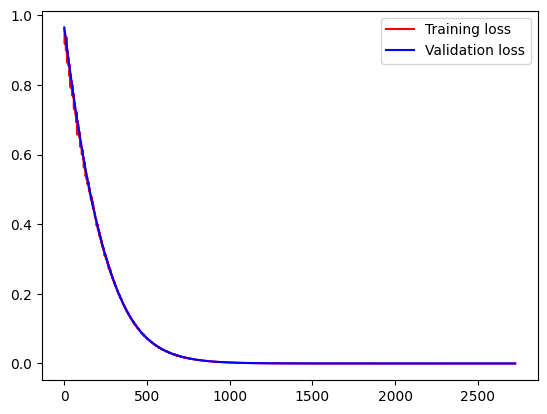

In [ ]:
max_epochs = 10000 # Maximum number of epochs
# Optimiser with step size = lr (learning rate)
optimiser = torch.optim.Adam(net.parameters(), lr=0.001)
# MSE loss
loss_fn = torch.nn.MSELoss(reduction="mean")

train_loss_list = list()
val_loss_list = list()

for epoch in range(max_epochs):
  print(f"Epoch: {epoch+1}/{max_epochs}")
  # Set ANN in training mode
  net.train()
  # Load data in minibatches
  for batch, (x_train, y_train) in enumerate(customDataLoader_train):
    # Forward pass
    y_pred = net(x_train)
    # Error measurement
    loss_train = loss_fn(y_pred, y_train)
    print(f"Training: Batch {batch+1}/{len(customDataLoader_train)}, Loss: {loss_train.item()}")
    # Calculate gradient
    loss_train.backward()
    # Parameter update
    optimiser.step()
    # Reset the gradients
    optimiser.zero_grad()
  # Save training loss
  train_loss_list.append(loss_train.item())

  # Stop gradient tracking
  with torch.no_grad():
    # Set ANN for validation mode
    net.eval()
    # Load validation data
    for batch, (x_val, y_val) in enumerate(customDataLoader_val):
      # Forward pass
      y_pred = net(x_val)
      # Error measurement
      loss_val = loss_fn(y_pred, y_val)
      # Save validation loss
      val_loss_list.append(loss_val.item())
      print(f"Validation: Batch {batch+1}/{len(customDataLoader_val)}, Loss: {loss_val.item()}")
    # Save best model
    if epoch == 0:
      min_val_loss = loss_val
      torch.save(net, "best_model.pth")
    if loss_val <= min_val_loss:
      min_val_loss = loss_val
      torch.save(net, "best_model.pth")
    if loss_val > min_val_loss and epoch != 0:
      print(f"Epoch: {epoch+1}, Early stopping criteria invoked, stopping training")
      print(f"Minimum validation loss: {min_val_loss}, Current loss: {loss_val}")
      net.load_state_dict(torch.load("best_model.pth").state_dict())
      break

plt.plot(train_loss_list, "r-", label="Training loss")
plt.plot(val_loss_list, "b-", label="Validation loss")
plt.legend(loc="best")

**Testing phase**

Finally, we compare the predictions from the trained ANN and True value. We also compare the weights and bias with true values.

In [ ]:
print(f"True w1: {w1}")
print(f"True b1: {b1}")
# print(f"True w2: {w2}")
# print(f"True b2: {b2}")

print(f"ANN w1: {list(net.parameters())[0]}")
print(f"ANN b1: {list(net.parameters())[1]}")
# print(f"ANN w2: list(net.parameters())[2]")
# print(f"ANN b2: list(net.parameters())[3]")

num_test_samples = 25
x_test = (torch.rand(num_test_samples, sample_dim)).to(device=device).to(dtype=dtype)
x_np = x_test.cpu().numpy()

y_test = (torch.sin(torch.matmul(w1, x_test.T) + b1).T).to(device=device).to(dtype=dtype)
y_np = y_test.cpu().numpy()
y_pred = net(x_test)
y_pred = y_pred.detach().cpu().numpy()

print(f"\n True: \n {y_np[:10, :3]}")
print(f"\n Prediction: \n {y_pred[:10, :3]}")

'''
plt.plot(x_np[:, 0], y_np[:, 0], "r*", label="True x0y0")
plt.plot(x_np[:, 0], y_pred[:, 0], "bo", label="Pred x0y0")
plt.legend(loc="best")
'''

True w1: tensor([[0.8575, 0.2549],
        [0.5864, 0.7975],
        [0.4002, 0.0396]], device='cuda:0')
True b1: tensor([[0.1713],
        [0.6196],
        [0.5936]], device='cuda:0')
ANN w1: Parameter containing:
tensor([[0.8575, 0.2549],
        [0.5864, 0.7975],
        [0.4002, 0.0396]], device='cuda:0', requires_grad=True)
ANN b1: Parameter containing:
tensor([0.1713, 0.6196, 0.5936], device='cuda:0', requires_grad=True)

 True: 
 [[0.33934358 0.8629901  0.5946189 ]
 [0.7592675  0.9724872  0.7739415 ]
 [0.7263441  0.9789151  0.7539452 ]
 [0.6212493  0.82387877 0.734954  ]
 [0.71432376 0.9882895  0.74314374]
 [0.8571523  0.99461466 0.8043892 ]
 [0.6413591  0.9287359  0.7253761 ]
 [0.77907246 0.9988225  0.7617909 ]
 [0.67624545 0.98574036 0.7245797 ]
 [0.4323277  0.89868766 0.6311364 ]]

 Prediction: 
 [[0.33934316 0.8629864  0.5946165 ]
 [0.7592665  0.972485   0.77393895]
 [0.72634315 0.97891307 0.7539426 ]
 [0.6212484  0.8238749  0.73495144]
 [0.71432287 0.9882879  0.7431411 ]
 

'\nplt.plot(x_np[:, 0], y_np[:, 0], "r*", label="True x0y0")\nplt.plot(x_np[:, 0], y_pred[:, 0], "bo", label="Pred x0y0")\nplt.legend(loc="best")\n'

**Few tasks:**

1. Use np.random.shuffle to shuffle data before splitting into training and validation
2. Change input and output dimensions and observe the testing phase.
3. Change data type to torch.float64 or torch.float16 and observe the training phase.
4. Set activation function to identity and observe the predictions.
5. How to find correct dimension of hidden layer and number of layers in real problems?